# Idea: Compare overall process times of instances

-> Sum the process time for a serial number and compare the times on the time axis

## 1. Group SerialNumbers based on their Stations

Idea: Items (Serial Numbers) can be compared by selecting their stations. All items with the same station order form a Group.

In [32]:
import pandas as pd

# Load the data from JSON
data = pd.read_json("production_data_mock.json")

# Create a dictionary to store unique stations per serial number as a single string
stations_per_item = {}

for serial_number in data["SerialNumber"].unique():
    # Get unique stations for the current serial number and join them into a single string
    unique_stations = ", ".join(data[data["SerialNumber"] == serial_number]["StationName"].unique())
    stations_per_item[serial_number] = unique_stations

# Convert the dictionary to a DataFrame for easy comparison
stations_per_item_df = pd.DataFrame(list(stations_per_item.items()), columns=["SerialNumber", "Stations"])

# Identify unique station groups and assign a group ID for each unique set of stations
stations_per_item_df["Group_ID"] = stations_per_item_df.groupby("Stations").ngroup()

# Sort the DataFrame by Group_ID for easier viewing
stations_per_item_df = stations_per_item_df.sort_values(by="Group_ID").reset_index(drop=True)

# Display the DataFrame with groups
stations_per_item_df


,SerialNumber,Stations,Group_ID
0,1,Station1,0
1,128,Station1,0
2,129,Station1,0
3,130,Station1,0
4,131,Station1,0
...,...,...,...
195,71,Station1,0
196,72,Station1,0
197,73,Station1,0
198,63,Station1,0


# 2. Enrich Groups with Timestamp and compute overall process time

To be able to filter the occurences by time, we add the first check in time from each serial number -> This is the time where an item entered the production line

In the next step, we calculcate the total process time for each item.

In [33]:
first_occurrences = data.loc[data.groupby("SerialNumber")["TimeStamp"].idxmin()]

first_occurrences = first_occurrences[['SerialNumber', 'TimeStamp']]

first_occurrences

,SerialNumber,TimeStamp
0,1,2024-11-22 16:03:52.351142
1,2,2024-11-22 16:04:05.659106
2,3,2024-11-22 16:04:18.792870
3,4,2024-11-22 16:04:32.782839
4,5,2024-11-22 16:04:46.302688
...,...,...
195,196,2024-11-22 16:50:13.910363
196,197,2024-11-22 16:50:27.624331
197,198,2024-11-22 16:50:40.889065
198,199,2024-11-22 16:50:54.350271


In [34]:
processtime_per_station = data.groupby("SerialNumber")["Value"].sum()

stations_per_item_df = pd.merge(stations_per_item_df, processtime_per_station, on="SerialNumber", how="inner")

stations_per_item_df = stations_per_item_df.rename(columns={"Value":"ProcessTime"})
stations_per_item_df = pd.merge(stations_per_item_df, first_occurrences, on='SerialNumber', how='inner')

stations_per_item_df = stations_per_item_df.rename(columns={'TimeStamp':'FirstCheckIn'})

stations_per_item_df

,SerialNumber,Stations,Group_ID,ProcessTime,FirstCheckIn
0,1,Station1,0,13.307964,2024-11-22 16:03:52.351142
1,128,Station1,0,14.260144,2024-11-22 16:32:36.121441
2,129,Station1,0,14.738866,2024-11-22 16:32:50.381585
3,130,Station1,0,14.331161,2024-11-22 16:33:05.120451
4,131,Station1,0,14.564282,2024-11-22 16:33:19.451612
...,...,...,...,...,...
195,71,Station1,0,13.700416,2024-11-22 16:19:40.328081
196,72,Station1,0,13.048207,2024-11-22 16:19:54.028497
197,73,Station1,0,13.902756,2024-11-22 16:20:07.076704
198,63,Station1,0,13.071823,2024-11-22 16:17:53.377397


## 3. Compute statistical variables for each Group

In [35]:
# Ensure ProcessTime is numeric and valid
stations_per_item_df["ProcessTime"] = pd.to_numeric(stations_per_item_df["ProcessTime"], errors="coerce")

# Calculate the 25th percentile for each Group_ID
q25_values = (
    stations_per_item_df.groupby("Group_ID")["ProcessTime"]
    .quantile(0.25)
    .reset_index()
    .rename(columns={"ProcessTime": "Q25"})
)

q75_values = (
    stations_per_item_df.groupby("Group_ID")["ProcessTime"]
    .quantile(0.75)
    .reset_index()
    .rename(columns={"ProcessTime": "Q75"})
)

q90_values = (
    stations_per_item_df.groupby("Group_ID")["ProcessTime"]
    .quantile(0.90)
    .reset_index()
    .rename(columns={"ProcessTime": "Q90"})
)

median_values = (
    stations_per_item_df.groupby("Group_ID")["ProcessTime"]
    .median()
    .reset_index()
    .rename(columns={"ProcessTime": "Median"})
)

# Merge statistical values into dataset
stations_per_item_df = pd.merge(stations_per_item_df, q25_values, on="Group_ID", how="left")
stations_per_item_df = pd.merge(stations_per_item_df, q90_values, on="Group_ID", how="left")
stations_per_item_df = pd.merge(stations_per_item_df, q75_values, on="Group_ID", how="left")
stations_per_item_df = pd.merge(stations_per_item_df, median_values, on="Group_ID", how="left")


## 4. Combine items in a group into TimeGroups based on their CheckIn

This allows to see changes in charges of items

In [36]:
stations_per_item_df_subgrouped = stations_per_item_df.sort_values(by=["Group_ID", "FirstCheckIn"])

stations_per_item_df_subgrouped["TimeGroup"] = stations_per_item_df_subgrouped.groupby("Group_ID").cumcount() // 10 + 1

stations_per_item_df_subgrouped

,SerialNumber,Stations,Group_ID,ProcessTime,FirstCheckIn,Q25,Q90,Q75,Median,TimeGroup
0,1,Station1,0,13.307964,2024-11-22 16:03:52.351142,13.319744,15.751151,14.616111,13.753071,1
126,2,Station1,0,13.133764,2024-11-22 16:04:05.659106,13.319744,15.751151,14.616111,13.753071,1
127,3,Station1,0,13.989969,2024-11-22 16:04:18.792870,13.319744,15.751151,14.616111,13.753071,1
128,4,Station1,0,13.519849,2024-11-22 16:04:32.782839,13.319744,15.751151,14.616111,13.753071,1
129,5,Station1,0,13.431072,2024-11-22 16:04:46.302688,13.319744,15.751151,14.616111,13.753071,1
...,...,...,...,...,...,...,...,...,...,...
69,196,Station1,0,13.713968,2024-11-22 16:50:13.910363,13.319744,15.751151,14.616111,13.753071,20
70,197,Station1,0,13.264734,2024-11-22 16:50:27.624331,13.319744,15.751151,14.616111,13.753071,20
71,198,Station1,0,13.461206,2024-11-22 16:50:40.889065,13.319744,15.751151,14.616111,13.753071,20
186,199,Station1,0,13.641783,2024-11-22 16:50:54.350271,13.319744,15.751151,14.616111,13.753071,20


## 5. Calculate Exponentially Weighted Moving Average for each TimeGroup in a Group

In [37]:
import numpy as np
# Calculate Drift Indicator for each Group_ID and TimeGroup
alpha = 0.3  # EWMA smoothing factor
drift_threshold = 0.5  # Threshold for Drift Indicator

# Group by Group_ID and TimeGroup
grouped = stations_per_item_df_subgrouped.groupby(["Group_ID", "TimeGroup"])

# Apply calculations within each group
results = []
for (group_id, time_group), group_data in grouped:
    group_data = group_data.copy()
    group_data["EWMA"] = group_data["ProcessTime"].ewm(alpha=alpha, adjust=False).mean()
    group_data["EWMA_DriftIndicator"] = group_data["ProcessTime"] - group_data["EWMA"]
    group_data["EWMA_Alert"] = np.abs(group_data["EWMA_DriftIndicator"]) > drift_threshold
    results.append(group_data)

# Combine processed groups into a single DataFrame
processed_df = pd.concat(results).reset_index(drop=True)

processed_df

,SerialNumber,Stations,Group_ID,ProcessTime,FirstCheckIn,Q25,Q90,Q75,Median,TimeGroup,EWMA,EWMA_DriftIndicator,EWMA_Alert
0,1,Station1,0,13.307964,2024-11-22 16:03:52.351142,13.319744,15.751151,14.616111,13.753071,1,13.307964,0.000000,False
1,2,Station1,0,13.133764,2024-11-22 16:04:05.659106,13.319744,15.751151,14.616111,13.753071,1,13.255704,-0.121940,False
2,3,Station1,0,13.989969,2024-11-22 16:04:18.792870,13.319744,15.751151,14.616111,13.753071,1,13.475983,0.513985,True
3,4,Station1,0,13.519849,2024-11-22 16:04:32.782839,13.319744,15.751151,14.616111,13.753071,1,13.489143,0.030706,False
4,5,Station1,0,13.431072,2024-11-22 16:04:46.302688,13.319744,15.751151,14.616111,13.753071,1,13.471722,-0.040649,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,196,Station1,0,13.713968,2024-11-22 16:50:13.910363,13.319744,15.751151,14.616111,13.753071,20,13.606538,0.107430,False
196,197,Station1,0,13.264734,2024-11-22 16:50:27.624331,13.319744,15.751151,14.616111,13.753071,20,13.503997,-0.239262,False
197,198,Station1,0,13.461206,2024-11-22 16:50:40.889065,13.319744,15.751151,14.616111,13.753071,20,13.491159,-0.029954,False
198,199,Station1,0,13.641783,2024-11-22 16:50:54.350271,13.319744,15.751151,14.616111,13.753071,20,13.536347,0.105437,False


## 6. Test using Group 817

In [38]:
group817 = processed_df[processed_df['Group_ID'] == 0]

group817_unique_timestamps = group817.drop_duplicates(subset=["FirstCheckIn"])

group817_unique_timestamps

,SerialNumber,Stations,Group_ID,ProcessTime,FirstCheckIn,Q25,Q90,Q75,Median,TimeGroup,EWMA,EWMA_DriftIndicator,EWMA_Alert
0,1,Station1,0,13.307964,2024-11-22 16:03:52.351142,13.319744,15.751151,14.616111,13.753071,1,13.307964,0.000000,False
1,2,Station1,0,13.133764,2024-11-22 16:04:05.659106,13.319744,15.751151,14.616111,13.753071,1,13.255704,-0.121940,False
2,3,Station1,0,13.989969,2024-11-22 16:04:18.792870,13.319744,15.751151,14.616111,13.753071,1,13.475983,0.513985,True
3,4,Station1,0,13.519849,2024-11-22 16:04:32.782839,13.319744,15.751151,14.616111,13.753071,1,13.489143,0.030706,False
4,5,Station1,0,13.431072,2024-11-22 16:04:46.302688,13.319744,15.751151,14.616111,13.753071,1,13.471722,-0.040649,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,196,Station1,0,13.713968,2024-11-22 16:50:13.910363,13.319744,15.751151,14.616111,13.753071,20,13.606538,0.107430,False
196,197,Station1,0,13.264734,2024-11-22 16:50:27.624331,13.319744,15.751151,14.616111,13.753071,20,13.503997,-0.239262,False
197,198,Station1,0,13.461206,2024-11-22 16:50:40.889065,13.319744,15.751151,14.616111,13.753071,20,13.491159,-0.029954,False
198,199,Station1,0,13.641783,2024-11-22 16:50:54.350271,13.319744,15.751151,14.616111,13.753071,20,13.536347,0.105437,False


In [62]:
grouped_df = (
    processed_df.groupby(["Group_ID", "TimeGroup"], as_index=False)
    .agg(
        AverageProcessTime=("ProcessTime", "mean"),
        FirstCheckIn=("FirstCheckIn", "first"),
        Alert=("EWMA_Alert", "any"),
        Q25=("ProcessTime", lambda x: x.quantile(0.25)),
        Q50=("ProcessTime", lambda x: x.quantile(0.50)),
        Q75=("ProcessTime", lambda x: x.quantile(0.75)),
        Q90=("ProcessTime", lambda x: x.quantile(0.90)),
    )
)

grouped_df

,Group_ID,TimeGroup,AverageProcessTime,FirstCheckIn,Alert,Q25,Q50,Q75,Q90
0,0,1,13.534178,2024-11-22 16:03:52.351142,True,13.225723,13.475461,13.830962,13.983350
1,0,2,13.545479,2024-11-22 16:06:07.692920,False,13.297866,13.582443,13.745233,13.916060
2,0,3,13.530002,2024-11-22 16:08:23.147710,False,13.295143,13.474038,13.804495,13.939409
3,0,4,13.706152,2024-11-22 16:10:38.447733,False,13.452362,13.828454,13.924553,13.939591
4,0,5,13.381415,2024-11-22 16:12:55.509250,True,13.213565,13.278589,13.564608,13.688994
5,0,6,13.734773,2024-11-22 16:15:09.323397,False,13.554743,13.796731,13.854439,14.044570
6,0,7,13.365695,2024-11-22 16:17:26.671127,True,13.204013,13.324860,13.431261,13.650188
7,0,8,13.395886,2024-11-22 16:19:40.328081,False,13.072023,13.331187,13.670892,13.856323
8,0,9,13.443028,2024-11-22 16:21:54.286939,False,13.139092,13.304102,13.783513,13.931539
9,0,10,13.400576,2024-11-22 16:24:08.717222,True,13.108799,13.272169,13.655758,13.919476


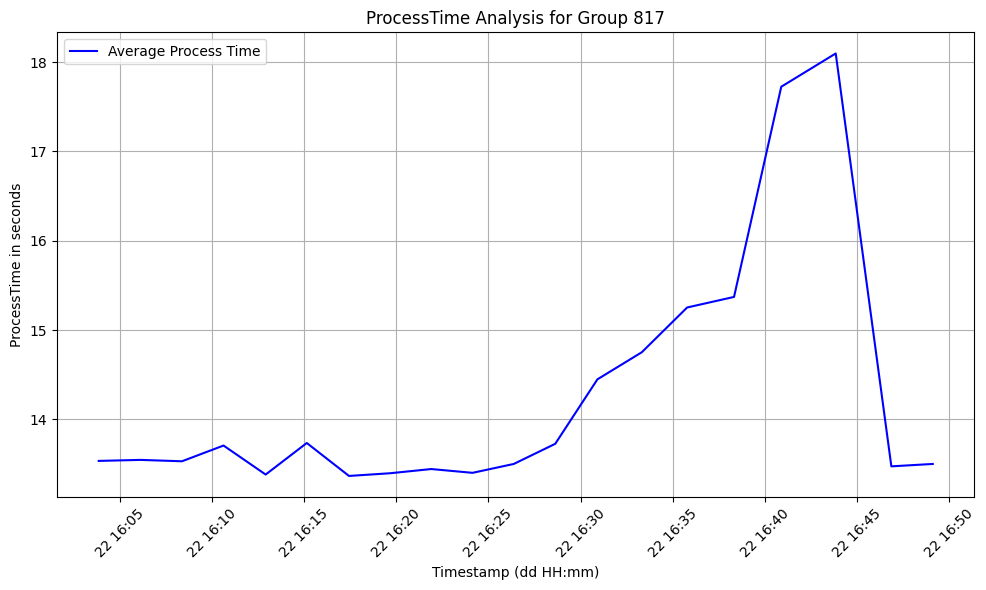

In [64]:
import matplotlib.pyplot as plt

# Plotting the DriftIndicator values
plt.figure(figsize=(10, 6))
plt.plot(grouped_df["FirstCheckIn"], grouped_df["AverageProcessTime"], label="Average Process Time", color='b')
#plt.plot(group817_unique_timestamps["FirstCheckIn"], group817_unique_timestamps["Q25"], label="Q25", color='lightgreen')
#plt.plot(group817_unique_timestamps["FirstCheckIn"], group817_unique_timestamps["Median"], label="Median", color='g')
#plt.plot(group817_unique_timestamps["FirstCheckIn"], group817_unique_timestamps["Q75"], label="Q75", color='orange')
#plt.plot(group817_unique_timestamps["FirstCheckIn"], group817_unique_timestamps["Q90"], label="Q90", color='red')



# Formatting the plot
plt.title("ProcessTime Analysis for Group 817")
plt.xlabel("Timestamp (dd HH:mm)")
plt.ylabel("ProcessTime in seconds")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

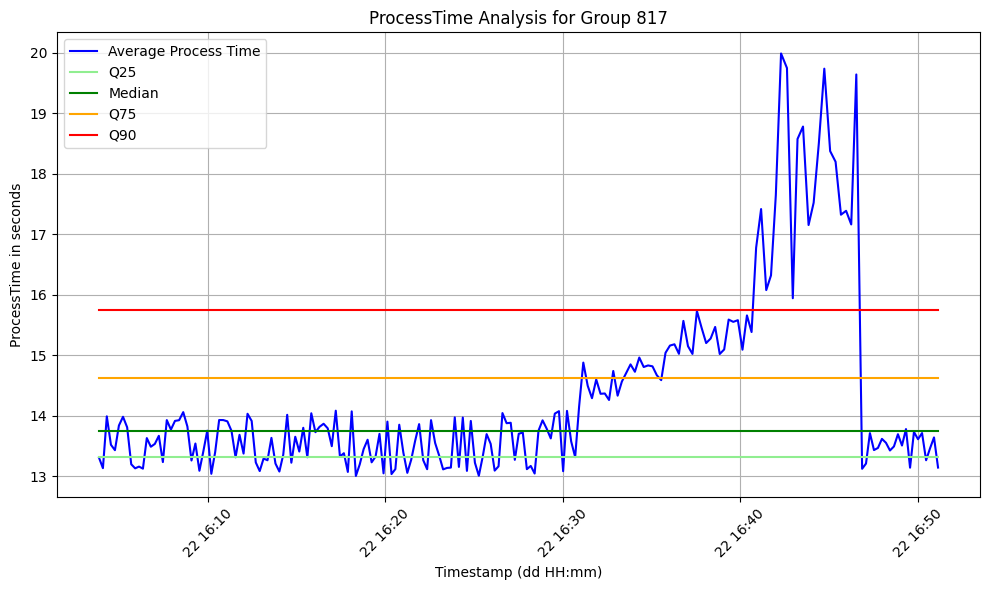

In [105]:
import matplotlib.pyplot as plt

# Plotting the DriftIndicator values
plt.figure(figsize=(10, 6))
plt.plot(processed_df["FirstCheckIn"], processed_df["ProcessTime"], label="Average Process Time", color='b')
plt.plot(group817_unique_timestamps["FirstCheckIn"], group817_unique_timestamps["Q25"], label="Q25", color='lightgreen')
plt.plot(group817_unique_timestamps["FirstCheckIn"], group817_unique_timestamps["Median"], label="Median", color='g')
plt.plot(group817_unique_timestamps["FirstCheckIn"], group817_unique_timestamps["Q75"], label="Q75", color='orange')
plt.plot(group817_unique_timestamps["FirstCheckIn"], group817_unique_timestamps["Q90"], label="Q90", color='red')



# Formatting the plot
plt.title("ProcessTime Analysis for Group 817")
plt.xlabel("Timestamp (dd HH:mm)")
plt.ylabel("ProcessTime in seconds")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

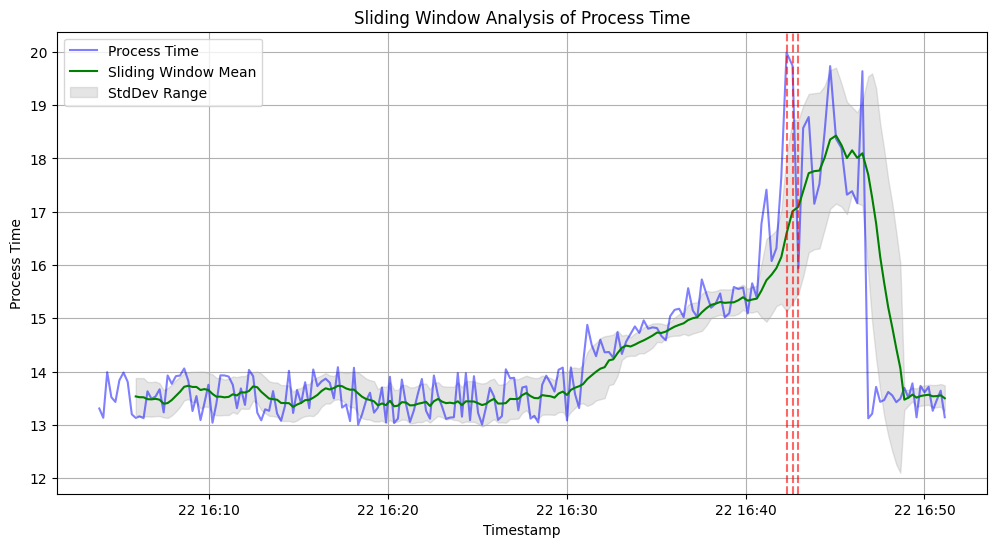

In [45]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Define sliding window size
WINDOW_SIZE = 10

# Extract the data for analysis
data817 = processed_df[processed_df["Group_ID"] == 0]
data817 = data817.sort_values("FirstCheckIn")  # Ensure data is sorted by time

# Initialize lists for sliding window results
sliding_means = []
sliding_std_devs = []
sliding_slopes = []
timestamps = []

# Perform sliding window analysis
for i in range(len(data817) - WINDOW_SIZE + 1):
    window = data817.iloc[i:i + WINDOW_SIZE]
    timestamps.append(window["FirstCheckIn"].iloc[-1])  # Take the last timestamp of the window

    # Calculate mean and standard deviation for the window
    sliding_means.append(window["ProcessTime"].mean())
    sliding_std_devs.append(window["ProcessTime"].std())

    # Fit a linear regression to the window
    X = np.arange(WINDOW_SIZE).reshape(-1, 1)
    y = window["ProcessTime"].values
    reg = LinearRegression().fit(X, y)
    sliding_slopes.append(reg.coef_[0])  # Extract the slope

# Convert results into a DataFrame for plotting
sliding_window_df = pd.DataFrame({
    "Timestamp": timestamps,
    "MeanProcessTime": sliding_means,
    "StdDevProcessTime": sliding_std_devs,
    "Slope": sliding_slopes
})

# Detect upward trends based on slope threshold
SLOPE_THRESHOLD = 0.3  # Adjust based on sensitivity
sliding_window_df["UpwardTrendDetected"] = sliding_window_df["Slope"] > SLOPE_THRESHOLD

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(data817["FirstCheckIn"], data817["ProcessTime"], label="Process Time", color="blue", alpha=0.5)
plt.plot(sliding_window_df["Timestamp"], sliding_window_df["MeanProcessTime"], label="Sliding Window Mean", color="green")
plt.fill_between(
    sliding_window_df["Timestamp"],
    sliding_window_df["MeanProcessTime"] - sliding_window_df["StdDevProcessTime"],
    sliding_window_df["MeanProcessTime"] + sliding_window_df["StdDevProcessTime"],
    color="gray", alpha=0.2, label="StdDev Range"
)

# Highlight upward trends
upward_trends = sliding_window_df[sliding_window_df["UpwardTrendDetected"]]
for ts in upward_trends["Timestamp"]:
    plt.axvline(x=ts, color="red", linestyle="--", alpha=0.6)

plt.title("Sliding Window Analysis of Process Time")
plt.xlabel("Timestamp")
plt.ylabel("Process Time")
plt.legend()
plt.grid(True)
plt.show()


In [56]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

# Define sliding window size and slope threshold
WINDOW_SIZE = 10
SLOPE_THRESHOLD = 0.3

# Initialize a list to store results for all groups
results = []

# Loop over each unique Group_ID
for group_id in processed_df["Group_ID"].unique():
    # Extract and sort the data for the current group
    group_data = processed_df[processed_df["Group_ID"] == group_id]
    group_data = group_data.sort_values("FirstCheckIn")

    # Initialize lists for sliding window results for the current group
    sliding_means = []
    sliding_std_devs = []
    sliding_slopes = []
    timestamps = []
    window_indices = []  # To store the window indicator
    serial_numbers = []  # To store serial numbers of the sliding window

    # Perform sliding window analysis
    for i in range(len(group_data) - WINDOW_SIZE + 1):
        window = group_data.iloc[i:i + WINDOW_SIZE]
        timestamps.append(window["FirstCheckIn"].iloc[-1])  # Take the last timestamp of the window
        window_indices.append(f"{i}-{i+WINDOW_SIZE-1}")  # Save the window range as an indicator

        # Concatenate serial numbers in the current window
        serial_numbers.append(", ".join(window["SerialNumber"].astype(str)))

        # Calculate mean and standard deviation for the window
        sliding_means.append(window["ProcessTime"].mean())
        sliding_std_devs.append(window["ProcessTime"].std())

        # Fit a linear regression to the window
        X = np.arange(WINDOW_SIZE).reshape(-1, 1)
        y = window["ProcessTime"].values
        reg = LinearRegression().fit(X, y)
        sliding_slopes.append(reg.coef_[0])  # Extract the slope

    # Store results for the current group
    group_results = pd.DataFrame({
        "Group_ID": group_id,
        "Timestamp": timestamps,
        "Window": window_indices,  # Add window indicator
        "SerialNumbers": serial_numbers,  # Add serial numbers
        "MeanProcessTime": sliding_means,
        "StdDevProcessTime": sliding_std_devs,
        "Slope": sliding_slopes
    })

    # Detect upward trends based on slope threshold
    group_results["UpwardTrendDetected"] = group_results["Slope"] > SLOPE_THRESHOLD

    # Append group results to the overall list
    results.append(group_results)

# Combine results for all groups into a single DataFrame
final_results = pd.concat(results, ignore_index=True)

# Display the final results
final_results



,Group_ID,Timestamp,Window,SerialNumbers,MeanProcessTime,StdDevProcessTime,Slope,UpwardTrendDetected
0,0,2024-11-22 16:05:54.561838,0-9,"1, 2, 3, 4, 5, 6, 7, 8, 9, 10",13.534178,0.345513,-0.001517,False
1,0,2024-11-22 16:06:07.692920,1-10,"2, 3, 4, 5, 6, 7, 8, 9, 10, 11",13.519364,0.359195,-0.037017,False
2,0,2024-11-22 16:06:20.852745,2-11,"3, 4, 5, 6, 7, 8, 9, 10, 11, 12",13.518573,0.360145,-0.084188,False
3,0,2024-11-22 16:06:33.978603,3-12,"4, 5, 6, 7, 8, 9, 10, 11, 12, 13",13.482634,0.323995,-0.046653,False
4,0,2024-11-22 16:06:47.609177,4-13,"5, 6, 7, 8, 9, 10, 11, 12, 13, 14",13.479434,0.323744,-0.043887,False
...,...,...,...,...,...,...,...,...
186,0,2024-11-22 16:50:13.910363,186-195,"187, 188, 189, 190, 191, 192, 193, 194, 195, 196",13.565504,0.189292,0.015516,False
187,0,2024-11-22 16:50:27.624331,187-196,"188, 189, 190, 191, 192, 193, 194, 195, 196, 197",13.536649,0.211993,-0.001704,False
188,0,2024-11-22 16:50:40.889065,188-197,"189, 190, 191, 192, 193, 194, 195, 196, 197, 198",13.540163,0.210240,-0.013192,False
189,0,2024-11-22 16:50:54.350271,189-198,"190, 191, 192, 193, 194, 195, 196, 197, 198, 199",13.555074,0.211780,-0.010814,False


In [68]:
processed_df

,SerialNumber,Stations,Group_ID,ProcessTime,FirstCheckIn,Q25,Q90,Q75,Median,TimeGroup,EWMA,EWMA_DriftIndicator,EWMA_Alert
0,1,Station1,0,13.307964,2024-11-22 16:03:52.351142,13.319744,15.751151,14.616111,13.753071,1,13.307964,0.000000,False
1,2,Station1,0,13.133764,2024-11-22 16:04:05.659106,13.319744,15.751151,14.616111,13.753071,1,13.255704,-0.121940,False
2,3,Station1,0,13.989969,2024-11-22 16:04:18.792870,13.319744,15.751151,14.616111,13.753071,1,13.475983,0.513985,True
3,4,Station1,0,13.519849,2024-11-22 16:04:32.782839,13.319744,15.751151,14.616111,13.753071,1,13.489143,0.030706,False
4,5,Station1,0,13.431072,2024-11-22 16:04:46.302688,13.319744,15.751151,14.616111,13.753071,1,13.471722,-0.040649,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,196,Station1,0,13.713968,2024-11-22 16:50:13.910363,13.319744,15.751151,14.616111,13.753071,20,13.606538,0.107430,False
196,197,Station1,0,13.264734,2024-11-22 16:50:27.624331,13.319744,15.751151,14.616111,13.753071,20,13.503997,-0.239262,False
197,198,Station1,0,13.461206,2024-11-22 16:50:40.889065,13.319744,15.751151,14.616111,13.753071,20,13.491159,-0.029954,False
198,199,Station1,0,13.641783,2024-11-22 16:50:54.350271,13.319744,15.751151,14.616111,13.753071,20,13.536347,0.105437,False


In [77]:
# Step 1: Expand SerialNumbers to create a mapping of SerialNumber to UpwardTrendDetected
trend_mapping = (
    group_results
    .explode("SerialNumbers")  # Split concatenated serial numbers into individual rows
    .assign(SerialNumbers=lambda df: df["SerialNumbers"].str.split(", "))  # Split serial numbers
    .explode("SerialNumbers")  # Flatten the lists into rows
    .drop_duplicates(subset=["SerialNumbers", "UpwardTrendDetected"])  # Remove duplicates
    .rename(columns={"SerialNumbers": "SerialNumber"})  # Rename for merging
    [["SerialNumber", "UpwardTrendDetected"]]  # Select relevant columns
)

trend_mapping["SerialNumber"] = trend_mapping["SerialNumber"].astype(int)
# Step 2: Merge with the new dataset
result_report = pd.merge(trend_mapping,processed_df, on="SerialNumber", how="right")

trend_column = result_report.pop("UpwardTrendDetected")
result_report["UpwardTrendDetected"] = trend_column
# Step 3: Inspect the resulting dataset
result_report


,SerialNumber,Stations,Group_ID,ProcessTime,FirstCheckIn,Q25,Q90,Q75,Median,TimeGroup,EWMA,EWMA_DriftIndicator,EWMA_Alert,UpwardTrendDetected
0,1,Station1,0,13.307964,2024-11-22 16:03:52.351142,13.319744,15.751151,14.616111,13.753071,1,13.307964,0.000000,False,False
1,2,Station1,0,13.133764,2024-11-22 16:04:05.659106,13.319744,15.751151,14.616111,13.753071,1,13.255704,-0.121940,False,False
2,3,Station1,0,13.989969,2024-11-22 16:04:18.792870,13.319744,15.751151,14.616111,13.753071,1,13.475983,0.513985,True,False
3,4,Station1,0,13.519849,2024-11-22 16:04:32.782839,13.319744,15.751151,14.616111,13.753071,1,13.489143,0.030706,False,False
4,5,Station1,0,13.431072,2024-11-22 16:04:46.302688,13.319744,15.751151,14.616111,13.753071,1,13.471722,-0.040649,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207,196,Station1,0,13.713968,2024-11-22 16:50:13.910363,13.319744,15.751151,14.616111,13.753071,20,13.606538,0.107430,False,False
208,197,Station1,0,13.264734,2024-11-22 16:50:27.624331,13.319744,15.751151,14.616111,13.753071,20,13.503997,-0.239262,False,False
209,198,Station1,0,13.461206,2024-11-22 16:50:40.889065,13.319744,15.751151,14.616111,13.753071,20,13.491159,-0.029954,False,False
210,199,Station1,0,13.641783,2024-11-22 16:50:54.350271,13.319744,15.751151,14.616111,13.753071,20,13.536347,0.105437,False,False


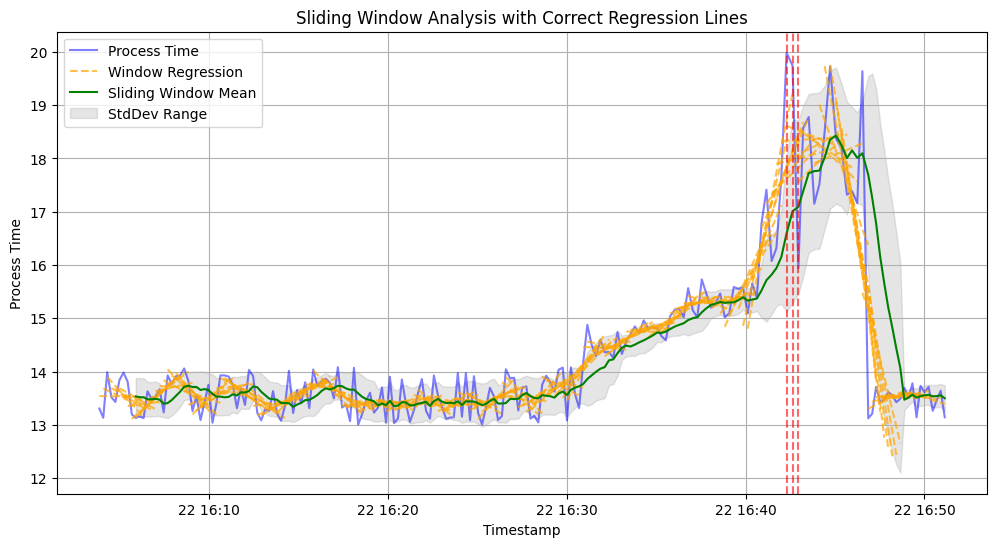

In [46]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Define sliding window size
WINDOW_SIZE = 10

# Extract the data for analysis
data817 = processed_df[processed_df["Group_ID"] == 0]
data817 = data817.sort_values("FirstCheckIn")  # Ensure data is sorted by time

# Initialize lists for sliding window results
sliding_means = []
sliding_std_devs = []
sliding_slopes = []
timestamps = []

# Plot setup
plt.figure(figsize=(12, 6))
plt.plot(data817["FirstCheckIn"], data817["ProcessTime"], label="Process Time", color="blue", alpha=0.5)

# Perform sliding window analysis
for i in range(len(data817) - WINDOW_SIZE + 1):
    window = data817.iloc[i:i + WINDOW_SIZE]
    timestamps.append(window["FirstCheckIn"].iloc[-1])  # Take the last timestamp of the window

    # Calculate mean and standard deviation for the window
    sliding_means.append(window["ProcessTime"].mean())
    sliding_std_devs.append(window["ProcessTime"].std())

    # Fit a linear regression to the window
    X = np.arange(WINDOW_SIZE).reshape(-1, 1)  # Sequential indices for the window
    y = window["ProcessTime"].values
    reg = LinearRegression().fit(X, y)
    sliding_slopes.append(reg.coef_[0])  # Extract the slope

    # Plot the regression line for the window
    x_window = window["FirstCheckIn"].values  # Use actual timestamps for x-axis
    y_window = reg.predict(X)
    plt.plot(x_window, y_window, color="orange", linestyle="--", alpha=0.7, label="Window Regression" if i == 0 else "")

# Convert results into a DataFrame for further analysis
sliding_window_df = pd.DataFrame({
    "Timestamp": timestamps,
    "MeanProcessTime": sliding_means,
    "StdDevProcessTime": sliding_std_devs,
    "Slope": sliding_slopes
})

# Detect upward trends based on slope threshold
SLOPE_THRESHOLD = 0.3  # Adjust based on sensitivity
sliding_window_df["UpwardTrendDetected"] = sliding_window_df["Slope"] > SLOPE_THRESHOLD

# Plot sliding window mean and standard deviation range
plt.plot(sliding_window_df["Timestamp"], sliding_window_df["MeanProcessTime"], label="Sliding Window Mean", color="green")
plt.fill_between(
    sliding_window_df["Timestamp"],
    sliding_window_df["MeanProcessTime"] - sliding_window_df["StdDevProcessTime"],
    sliding_window_df["MeanProcessTime"] + sliding_window_df["StdDevProcessTime"],
    color="gray", alpha=0.2, label="StdDev Range"
)

# Highlight upward trends
upward_trends = sliding_window_df[sliding_window_df["UpwardTrendDetected"]]
for ts in upward_trends["Timestamp"]:
    plt.axvline(x=ts, color="red", linestyle="--", alpha=0.6)

# Finalize the plot
plt.title("Sliding Window Analysis with Correct Regression Lines")
plt.xlabel("Timestamp")
plt.ylabel("Process Time")
plt.legend()
plt.grid(True)
plt.show()




IndexError: index 200 is out of bounds for axis 0 with size 200

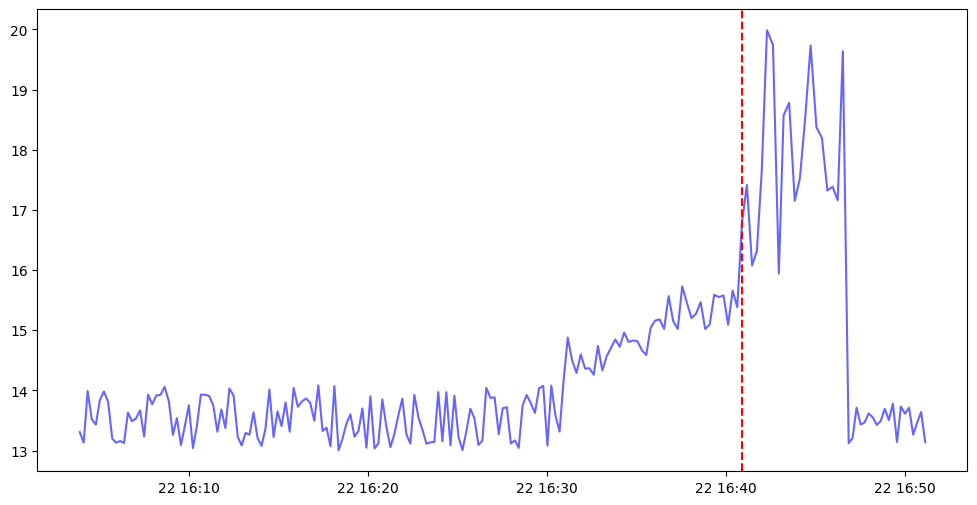

In [47]:
import ruptures as rpt
import matplotlib.pyplot as plt

# Assuming 'data817' is your DataFrame with "FirstCheckIn" and "ProcessTime"
# We need to detect the change points in the "ProcessTime" series

# Use "ProcessTime" as the input for change point detection
process_times = data817["ProcessTime"].values

# Set the model for change point detection, "l2" is for detecting mean shifts
model = "l2"  # You can also try "rbf", "normal", etc.
penalty = 10  # Adjust this penalty value as needed

# Pelt algorithm with penalty
algo = rpt.Pelt(model=model, min_size=2, jump=1).fit(process_times)

# Detect change points
change_points = algo.predict(pen=penalty)

# Plotting the results
plt.figure(figsize=(12, 6))

# Plot the original data
plt.plot(data817["FirstCheckIn"], process_times, label="Process Time", color="blue", alpha=0.6)

# Plot change points, only mark upward changes
for i in range(1, len(change_points)):  # Start from 1 to compare with the previous point
    prev_cp = change_points[i - 1]
    current_cp = change_points[i]
    
    # Check if the change is upward (i.e., ProcessTime increases after the change point)
    if process_times[current_cp] > process_times[prev_cp]:  # Upward trend
        plt.axvline(data817["FirstCheckIn"].iloc[current_cp], color="red", linestyle="--", label="Upward Change" if i == 1 else "")

plt.title("Upward Change Detection using Ruptures")
plt.xlabel("Timestamp")
plt.ylabel("Process Time")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()




In [78]:
result_report

,SerialNumber,Stations,Group_ID,ProcessTime,FirstCheckIn,Q25,Q90,Q75,Median,TimeGroup,EWMA,EWMA_DriftIndicator,EWMA_Alert,UpwardTrendDetected
0,1,Station1,0,13.307964,2024-11-22 16:03:52.351142,13.319744,15.751151,14.616111,13.753071,1,13.307964,0.000000,False,False
1,2,Station1,0,13.133764,2024-11-22 16:04:05.659106,13.319744,15.751151,14.616111,13.753071,1,13.255704,-0.121940,False,False
2,3,Station1,0,13.989969,2024-11-22 16:04:18.792870,13.319744,15.751151,14.616111,13.753071,1,13.475983,0.513985,True,False
3,4,Station1,0,13.519849,2024-11-22 16:04:32.782839,13.319744,15.751151,14.616111,13.753071,1,13.489143,0.030706,False,False
4,5,Station1,0,13.431072,2024-11-22 16:04:46.302688,13.319744,15.751151,14.616111,13.753071,1,13.471722,-0.040649,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207,196,Station1,0,13.713968,2024-11-22 16:50:13.910363,13.319744,15.751151,14.616111,13.753071,20,13.606538,0.107430,False,False
208,197,Station1,0,13.264734,2024-11-22 16:50:27.624331,13.319744,15.751151,14.616111,13.753071,20,13.503997,-0.239262,False,False
209,198,Station1,0,13.461206,2024-11-22 16:50:40.889065,13.319744,15.751151,14.616111,13.753071,20,13.491159,-0.029954,False,False
210,199,Station1,0,13.641783,2024-11-22 16:50:54.350271,13.319744,15.751151,14.616111,13.753071,20,13.536347,0.105437,False,False


In [100]:
import pandas as pd
from evidently.report import Report
from evidently.metrics import ColumnDriftMetric, DatasetDriftMetric, DatasetMissingValuesMetric
from evidently.metrics import ColumnQuantileMetric, ColumnCorrelationsMetric
import json
from datetime import datetime, timedelta

# Initialize an empty list to hold results
updated_result_report = []

# Group by Group_ID and process each group
for group_id, group_data in result_report.groupby("Group_ID"):
    # Find the maximum TimeGroup for the current group
    max_timegroup = group_data["TimeGroup"].max()
    
    # Split into Current and Reference
    current = group_data[group_data["TimeGroup"] == max_timegroup]
    reference = group_data[group_data["TimeGroup"] != max_timegroup]
    
    # Create the data drift report
    data_drift_report = Report(metrics=[
        ColumnDriftMetric(column_name='ProcessTime'),
        DatasetDriftMetric(),
        DatasetMissingValuesMetric(),
        ColumnQuantileMetric(column_name='ProcessTime', quantile=0.5),
        ColumnCorrelationsMetric(column_name='ProcessTime')
    ])
    
    # Run the data drift report
    data_drift_report.run(reference_data=reference[['ProcessTime']], current_data=current[['ProcessTime']])
    
    # Get the drift result in dictionary format
    drift_result = data_drift_report.as_dict()
    print(drift_result)
    
    # Extract the drift detection status
    drift_detected = drift_result['metrics'][0]['result']['drift_detected']
    print("Drift Detected:", drift_detected)
    
    # Add the drift_detected value only to the current data window
    current['Evidently_Drift_Detect'] = drift_detected
    
    # Merge the drift result back into the original group (result_report)
    updated_group_data = group_data.merge(current[['Group_ID', 'TimeGroup', 'Evidently_Drift_Detect']], 
                                          on=['Group_ID', 'TimeGroup'], 
                                          how='left')
    
    # Append the updated group to the results list
    updated_result_report.append(updated_group_data)

# Combine all the groups back into a single DataFrame
result_report_with_drift = pd.concat(updated_result_report, ignore_index=True)

# Print or return the result
result_report_with_drift = result_report_with_drift.drop(columns={"Drift_Detected_x", "Drift_Detected_y"})
result_report_with_drift = result_report_with_drift.drop_duplicates()

result_report_with_drift


{'metrics': [{'metric': 'ColumnDriftMetric', 'result': {'column_name': 'ProcessTime', 'column_type': 'num', 'stattest_name': 'K-S p_value', 'stattest_threshold': 0.05, 'drift_score': 0.004031063003674426, 'drift_detected': True, 'current': {'small_distribution': {'x': [13.141891874438407, 13.205705964458817, 13.269520054479225, 13.333334144499634, 13.397148234520044, 13.460962324540453, 13.524776414560861, 13.588590504581271, 13.65240459460168, 13.716218684622088, 13.780032774642498], 'y': [3.134104081653976, 1.5670520408270314, 0.0, 0.0, 0.0, 3.134104081654063, 0.0, 3.134104081653976, 1.5670520408270314, 3.134104081653976]}}, 'reference': {'small_distribution': {'x': [13.005312252761309, 13.703208886688351, 14.401105520615392, 15.099002154542433, 15.796898788469475, 16.494795422396518, 17.19269205632356, 17.8905886902506, 18.58848532417764, 19.286381958104684, 19.984278592031725], 'y': [0.6100367211427652, 0.3546725122923063, 0.14896245516276863, 0.12058865417938383, 0.042560701475076

,SerialNumber,Stations,Group_ID,ProcessTime,FirstCheckIn,Q25,Q90,Q75,Median,TimeGroup,EWMA,EWMA_DriftIndicator,EWMA_Alert,UpwardTrendDetected,Evidently_Drift_Detect
0,1,Station1,0,13.307964,2024-11-22 16:03:52.351142,13.319744,15.751151,14.616111,13.753071,1,13.307964,0.000000,False,False,NaN
1,2,Station1,0,13.133764,2024-11-22 16:04:05.659106,13.319744,15.751151,14.616111,13.753071,1,13.255704,-0.121940,False,False,NaN
2,3,Station1,0,13.989969,2024-11-22 16:04:18.792870,13.319744,15.751151,14.616111,13.753071,1,13.475983,0.513985,True,False,NaN
3,4,Station1,0,13.519849,2024-11-22 16:04:32.782839,13.319744,15.751151,14.616111,13.753071,1,13.489143,0.030706,False,False,NaN
4,5,Station1,0,13.431072,2024-11-22 16:04:46.302688,13.319744,15.751151,14.616111,13.753071,1,13.471722,-0.040649,False,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252,196,Station1,0,13.713968,2024-11-22 16:50:13.910363,13.319744,15.751151,14.616111,13.753071,20,13.606538,0.107430,False,False,True
262,197,Station1,0,13.264734,2024-11-22 16:50:27.624331,13.319744,15.751151,14.616111,13.753071,20,13.503997,-0.239262,False,False,True
272,198,Station1,0,13.461206,2024-11-22 16:50:40.889065,13.319744,15.751151,14.616111,13.753071,20,13.491159,-0.029954,False,False,True
282,199,Station1,0,13.641783,2024-11-22 16:50:54.350271,13.319744,15.751151,14.616111,13.753071,20,13.536347,0.105437,False,False,True


In [102]:
# Function to classify based on the quantile ranges
def classify_process_time(value, Q25, Q75, Q90):
    if value < Q25:
        return 'Danger'
    elif Q25 <= value < Q75:
        return 'Normal'
    elif Q75 <= value < Q90:
        return 'Danger'
    else:
        return 'Critical'

# Get the quantile values from the dataset
Q25 = result_report_with_drift['Q25'].iloc[0]
Q75 = result_report_with_drift['Q75'].iloc[0]
Q90 = result_report_with_drift['Q90'].iloc[0]

# Apply the classification function to the 'ProcessTime' column
result_report_with_drift['ProcessTime_Class'] = result_report_with_drift['ProcessTime'].apply(
    lambda x: classify_process_time(x, Q25, Q75, Q90)
)

result_report_with_drift.tail(50)


,SerialNumber,Stations,Group_ID,ProcessTime,FirstCheckIn,Q25,Q90,Q75,Median,TimeGroup,EWMA,EWMA_DriftIndicator,EWMA_Alert,UpwardTrendDetected,Evidently_Drift_Detect,ProcessTime_Class
162,160,Station1,0,15.383004,2024-11-22 16:40:37.806776,13.319744,15.751151,14.616111,13.753071,16,15.418148,-0.035144,False,False,NaN,Danger
163,160,Station1,0,15.383004,2024-11-22 16:40:37.806776,13.319744,15.751151,14.616111,13.753071,16,15.418148,-0.035144,False,True,NaN,Danger
164,161,Station1,0,16.774503,2024-11-22 16:40:53.189780,13.319744,15.751151,14.616111,13.753071,17,16.774503,0.000000,False,False,NaN,Critical
165,161,Station1,0,16.774503,2024-11-22 16:40:53.189780,13.319744,15.751151,14.616111,13.753071,17,16.774503,0.000000,False,True,NaN,Critical
166,162,Station1,0,17.414032,2024-11-22 16:41:09.964283,13.319744,15.751151,14.616111,13.753071,17,16.966362,0.447670,False,False,NaN,Critical
167,162,Station1,0,17.414032,2024-11-22 16:41:09.964283,13.319744,15.751151,14.616111,13.753071,17,16.966362,0.447670,False,True,NaN,Critical
168,163,Station1,0,16.075268,2024-11-22 16:41:27.378315,13.319744,15.751151,14.616111,13.753071,17,16.699034,-0.623766,True,False,NaN,Critical
169,163,Station1,0,16.075268,2024-11-22 16:41:27.378315,13.319744,15.751151,14.616111,13.753071,17,16.699034,-0.623766,True,True,NaN,Critical
170,164,Station1,0,16.318545,2024-11-22 16:41:43.453583,13.319744,15.751151,14.616111,13.753071,17,16.584887,-0.266343,False,False,NaN,Critical
171,164,Station1,0,16.318545,2024-11-22 16:41:43.453583,13.319744,15.751151,14.616111,13.753071,17,16.584887,-0.266343,False,True,NaN,Critical
